In [1]:
import os
import pickle
import re
import sys

import numpy as np
import torch
from PIL import Image
from torch import nn
from torch import optim
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import mnist

# Fixes: OMP Error #15
os.environ['KMP_DUPLICATE_LIB_OK'] = "True"

np.set_printoptions(linewidth=np.inf)
np.set_printoptions(threshold=sys.maxsize)

In [2]:
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.conv1 = nn.Conv2d(1, 4, 5)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(2)
        self.fc1 = nn.Linear(16, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.pool1(x)
        x = x.view(x.shape[0], -1)
        x = self.fc1(x)
        return x

In [3]:
def format_ndarray_for_solidity(a, a_name=None, dtype="int128"):
    ndim = a.ndim
    a = str(repr(a))
    a = re.sub(r'^array\(', r'', a)  # remove array metadata
    a = re.sub(r'^\s*$', r'', a, flags=re.MULTILINE)  # remove leading whitespace
    a = re.sub(r'^\s*', r'\t', a, flags=re.MULTILINE)  # align lines with tab
    a = re.sub(r'^(\s*)(\[{1,})\[', r'\2\n\1[', a, flags=re.MULTILINE)
    a = re.sub(r'(\]{1,})\]', r']\n\1', a)  # separate multiple brackets with newline
    a = re.sub(r'\], dtype=.*\)', r']', a)  # remove NumPy dtype metadata
    a = re.sub(r'\[([-,\s]*\d*),', r'[{}(\1),'.format(dtype), a)  # add dtype to first integer of each array
    a = a + ';'  # append semicolon
    a = re.sub(r'^\s*', r'', a)  # replace leading space on first line
    a = re.sub(r'\](\]{1,});$', r'\1\n];', a)  # move final bracket to separate line
    if a_name is not None:
        # Add dtype metadata and variable name.
        a = "int128{} {} = [".format('[]' * ndim, a_name.replace('.', '_')) + a[1:]
    a = re.sub(r'= \[(\[{1,})', r'= [\n\1', a)  # move leading bracket to separate line
    n_lines = len(a.split('\n'))
    if n_lines > 1 and ndim > 2:
        # Add tab to inner lines.
        a = '\n'.join(['\t' + a_line if (idx > 0 and idx < n_lines -1) else a_line
                       for idx, a_line in enumerate(a.split('\n'))])
    a = a.replace('\t', ' ' * 4)  # convert tabs to spaces
    return a

In [4]:
def do_train(model, train_dataset, test_dataset, n_epochs=100, batch_size=256):
    train_loader = DataLoader(train_dataset, batch_size=batch_size)
    test_loader = DataLoader(test_dataset, batch_size=batch_size)

    optimizer = optim.SGD(model.parameters(), lr=1e-1)
    loss_fn = nn.CrossEntropyLoss()

    for epoch in range(1, n_epochs + 1):
        model.train()
        for idx, (X_train, y_train) in enumerate(train_loader):
            optimizer.zero_grad()
            y_pred = model(X_train.float())
            loss = loss_fn(y_pred, y_train.long())
            loss.backward()
            optimizer.step()

        n_correct = 0
        n_total = 0
        model.eval()
        for idx, (X_test, y_test) in enumerate(test_loader):
            y_pred = model(X_test.float()).detach()
            y_pred = np.argmax(y_pred, axis=-1)
            label_np = y_test.numpy()
            y_acc = y_pred == y_test
            n_correct += np.sum(y_acc.numpy(), axis=-1)
            n_total += y_acc.shape[0]

        print("Epoch: {:3d}, loss: {:.5f}, acc: {:.4f}".format(
            epoch, loss.sum().item(), n_correct / n_total))

    return model


def do_test(model, test_dataset, batch_size=10000):
    test_loader = DataLoader(test_dataset, batch_size=batch_size)

    n_correct = 0
    n_total = 0
    model.eval()
    for idx, (X_test, y_test) in enumerate(test_loader):
        y_pred = model(X_test.float()).detach()
        y_pred = np.argmax(y_pred, axis=-1)
        label_np = y_test.numpy()
        y_acc = y_pred == y_test
        n_correct += np.sum(y_acc.numpy(), axis=-1)
        n_total += y_acc.shape[0]

    return n_correct, n_total

In [5]:
retrain = False

train_dataset = mnist.MNIST(
    root="./train",
    train=True,
    download=True,
    transform=transforms.Compose([
        transforms.Resize((8, 8)),
        transforms.ToTensor()
    ])
)
test_dataset = mnist.MNIST(
    root="./test",
    train=False,
    download=True,
    transform=transforms.Compose([
        transforms.Resize((8, 8)),
        transforms.ToTensor()
    ])
)

model = Model()

if retrain:
    print("Retraining...")
    model = do_train(model, train_dataset, test_dataset, n_epochs=10, batch_size=256)
    with open("model.pkl", 'wb') as f:
        pickle.dump(model.state_dict(), f)
else:
    print("Skipping training...")

print("Loading model weights...")
with open("model.pkl", 'rb') as f:
    weights = pickle.load(f)

Skipping training...
Loading model weights...


In [6]:
test_loader = DataLoader(test_dataset, batch_size=10000)

# Set model weights.
for param, weight in zip(model.parameters(), weights.values()):
    param.data = weight

n_correct, n_total = do_test(model, test_dataset, batch_size=10000)
print("Test Accuracy: {:.4f} ({}/{})".format(n_correct / n_total, n_correct, n_total))

Test Accuracy: 0.9032 (9032/10000)


In [7]:
test_loader = DataLoader(test_dataset, batch_size=10000)

# Set quantized model weights.
for param, weight in zip(model.parameters(), weights.values()):
    param.data = (weight * 255).type('torch.LongTensor').type('torch.FloatTensor')

n_correct, n_total = do_test(model, test_dataset, batch_size=10000)
print("Test Quantized Accuracy: {:.4f} ({}/{})".format(n_correct / n_total, n_correct, n_total))

Test Quantized Accuracy: 0.8985 (8985/10000)


Printing formatted example input image...
int128[][][] ex_image = [
    [
        [int128(  0),   0,   0,   0,   0,   0,   0,   0],
        [int128(  0),   5,  18,   7,   4,   4,   1,   0],
        [int128(  0),  32, 114, 117, 117, 125,  30,   0],
        [int128(  0),   2,   7,  18,  44, 139,  23,   0],
        [int128(  0),   0,   0,   1,  81,  83,   1,   0],
        [int128(  0),   0,   0,  35, 128,  18,   0,   0],
        [int128(  0),   0,   8, 127,  65,   0,   0,   0],
        [int128(  0),   0,  23, 128,  20,   0,   0,   0]
    ]
];



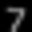

In [8]:
print("Printing formatted example input image...")
test_loader = DataLoader(test_dataset, batch_size=1)
_, (X_digit, y_digit) = next(enumerate(test_loader))

X_digit = (X_digit.numpy().reshape((1, 8, 8)) * 255).astype(np.uint8)

digit = format_ndarray_for_solidity(X_digit, "ex_image")
print(digit)
print()

Image.fromarray(X_digit.reshape((8, 8))).convert('RGB').resize((32, 32))

In [9]:
print("Printing formatted default model weights...")
for w_name, w in weights.items():
    w = (w.numpy() * 255).astype(np.int32)
    w_formatted = format_ndarray_for_solidity(w, "default_" + w_name)
    print(w_formatted)
    print()

Printing formatted default model weights...
int128[][][][] default_conv1_weight = [
    [[
        [int128(-213),   79,  176,  -10,  -78],
        [int128(-419),  103,  282,  -50,  201],
        [int128(-673),  418,  541, -163, -107],
        [int128(-461), -425,  543,  525,  -35],
        [int128(  77), -293, -489,   82,   23]
    ]],
    [[
        [int128(-470), -537, -330, -472, -196],
        [int128( 471), 1058,  774,  264,  -45],
        [int128(-293), -678,  -45,  399,  -52],
        [int128( -32),  -24, -275,  -84, -163],
        [int128(  43),   -1,   -9, -113, -217]
    ]],
    [[
        [int128(-131), -225, -255,  260,  265],
        [int128(   8),  444,  358,  455,  244],
        [int128( 313), -221, -615, -582, -362],
        [int128(  84), -268,   11, -622,  -57],
        [int128( 143),  -44,  -55, -119,  523]
    ]],
    [[
        [int128(  92),  141,  316,  397,  685],
        [int128(  84),  108,   45, -235,  422],
        [int128(-249),   64, -528,    0,  141],
   